In [2]:
!pip install optuna

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score,roc_auc_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
import optuna
from collections import Counter


In [5]:
tel=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
tel.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
tel.shape

(7043, 21)

In [10]:
tel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
tel.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [14]:
tel.duplicated().sum()

0

In [16]:
tel.isnull().sum()*100/tel.shape[0]

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [18]:
for col in tel.select_dtypes(include=object).columns:
    print(f"Column: {col}")
    print(pd.crosstab(tel[col],tel['Churn']))
    print("-" * 40)

Column: customerID
Churn       No  Yes
customerID         
0002-ORFBO   1    0
0003-MKNFE   1    0
0004-TLHLJ   0    1
0011-IGKFF   0    1
0013-EXCHZ   0    1
...         ..  ...
9987-LUTYD   1    0
9992-RRAMN   0    1
9992-UJOEL   1    0
9993-LHIEB   1    0
9995-HOTOH   1    0

[7043 rows x 2 columns]
----------------------------------------
Column: gender
Churn     No  Yes
gender           
Female  2549  939
Male    2625  930
----------------------------------------
Column: Partner
Churn      No   Yes
Partner            
No       2441  1200
Yes      2733   669
----------------------------------------
Column: Dependents
Churn         No   Yes
Dependents            
No          3390  1543
Yes         1784   326
----------------------------------------
Column: PhoneService
Churn           No   Yes
PhoneService            
No             512   170
Yes           4662  1699
----------------------------------------
Column: MultipleLines
Churn               No  Yes
MultipleLines             

In [20]:
pd.crosstab(tel['SeniorCitizen'], tel['Churn'])

Churn,No,Yes
SeniorCitizen,,
0,4508,1393
1,666,476


<Axes: xlabel='DeviceProtection', ylabel='count'>

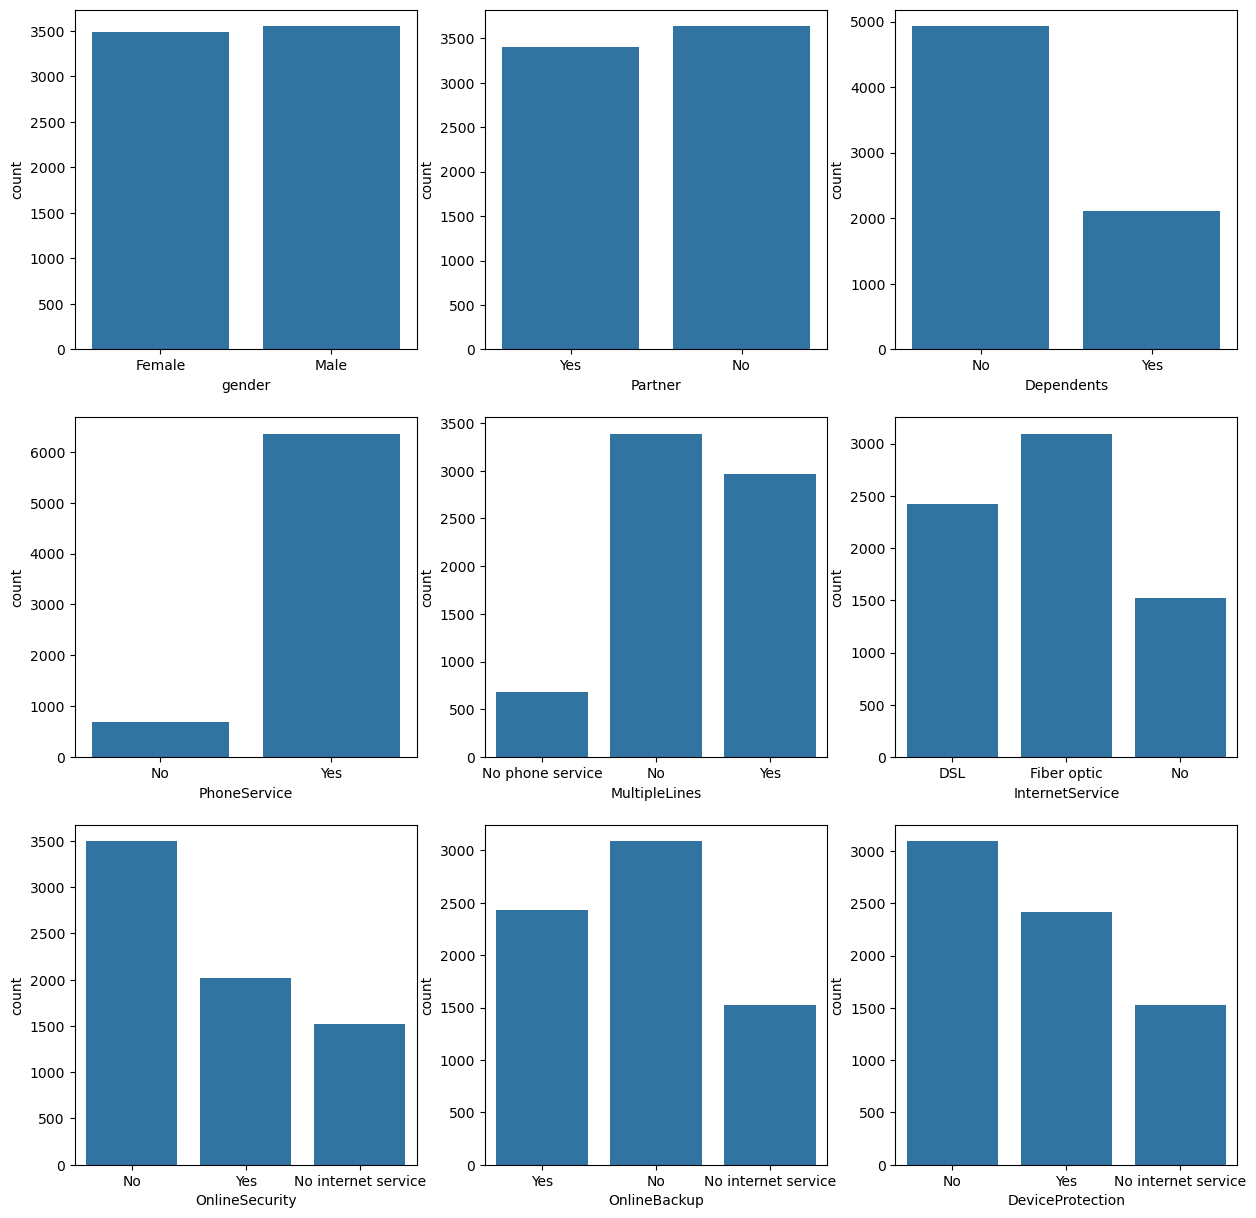

In [22]:
fig,axes=plt.subplots(3,3,figsize=(15,15))
sns.countplot(x='gender',data=tel,ax=axes[0,0])
sns.countplot(x='Partner',data=tel,ax=axes[0,1])
sns.countplot(x='Dependents',data=tel,ax=axes[0,2])
sns.countplot(x='PhoneService',data=tel,ax=axes[1,0])
sns.countplot(x='MultipleLines',data=tel,ax=axes[1,1])
sns.countplot(x='InternetService',data=tel,ax=axes[1,2])
sns.countplot(x='OnlineSecurity',data=tel,ax=axes[2,0])
sns.countplot(x='OnlineBackup',data=tel,ax=axes[2,1])
sns.countplot(x='DeviceProtection',data=tel,ax=axes[2,2])




<Axes: xlabel='Churn', ylabel='count'>

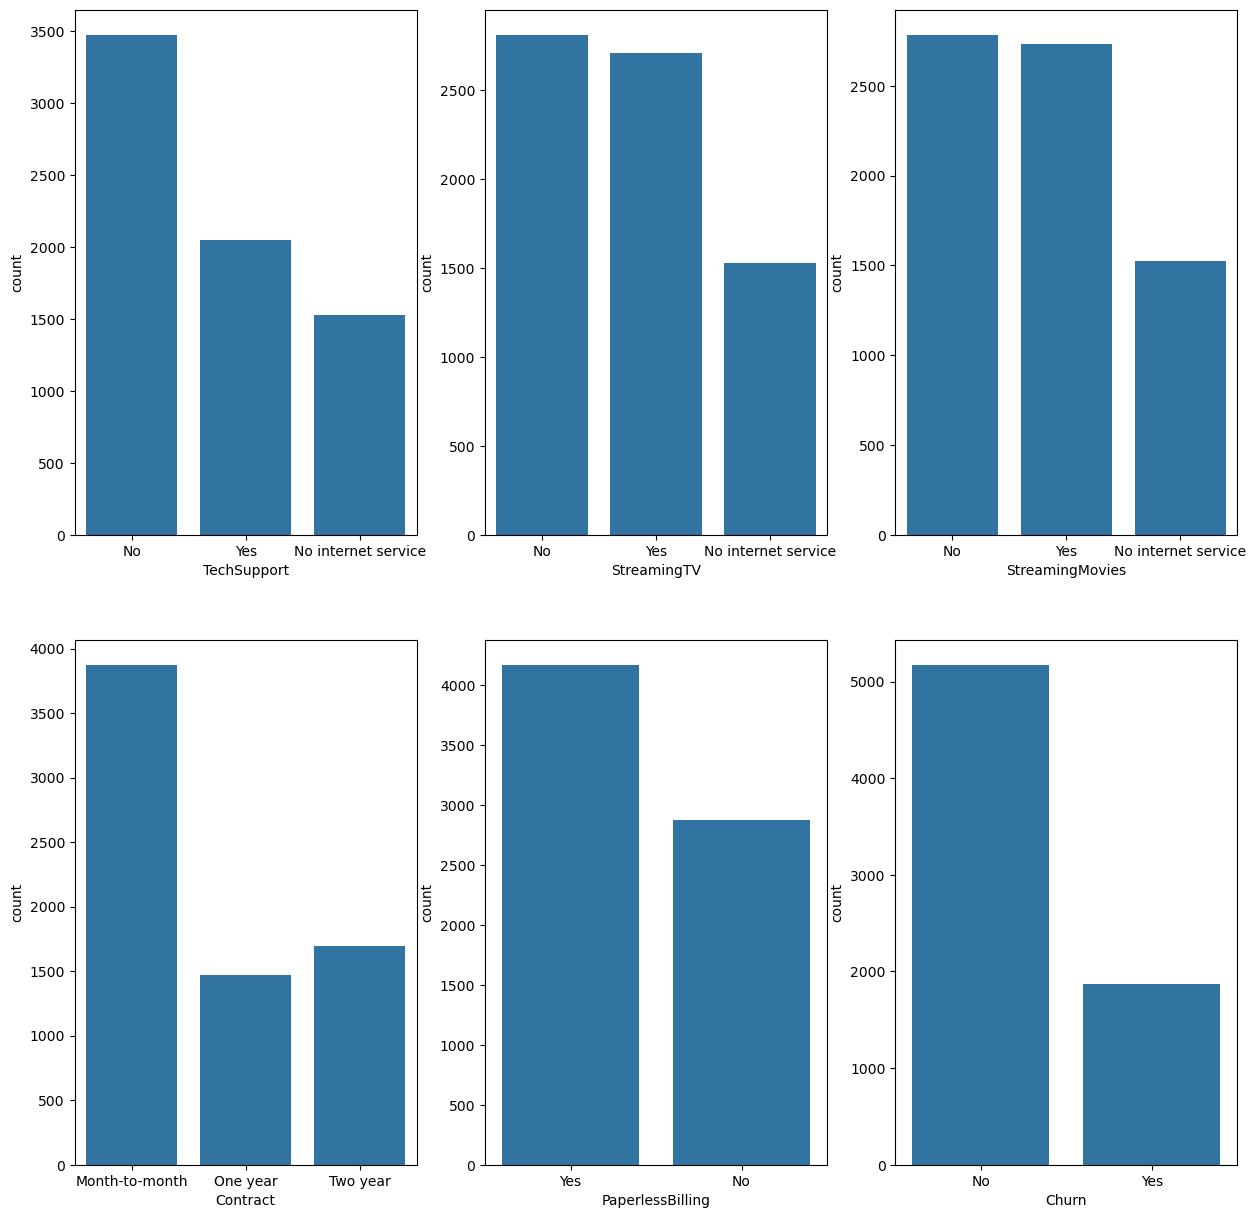

In [24]:
fig,axes=plt.subplots(2,3,figsize=(15,15))
sns.countplot(x='TechSupport',data=tel,ax=axes[0,0])
sns.countplot(x='StreamingTV',data=tel,ax=axes[0,1])
sns.countplot(x='StreamingMovies',data=tel,ax=axes[0,2])
sns.countplot(x='Contract',data=tel,ax=axes[1,0])
sns.countplot(x='PaperlessBilling',data=tel,ax=axes[1,1])
sns.countplot(x='Churn',data=tel,ax=axes[1,2])


<Axes: xlabel='SeniorCitizen', ylabel='count'>

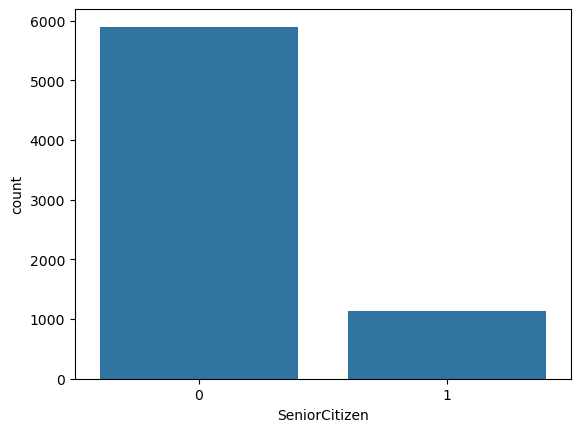

In [25]:
sns.countplot(x='SeniorCitizen',data=tel)


<Axes: xlabel='TotalCharges', ylabel='Count'>

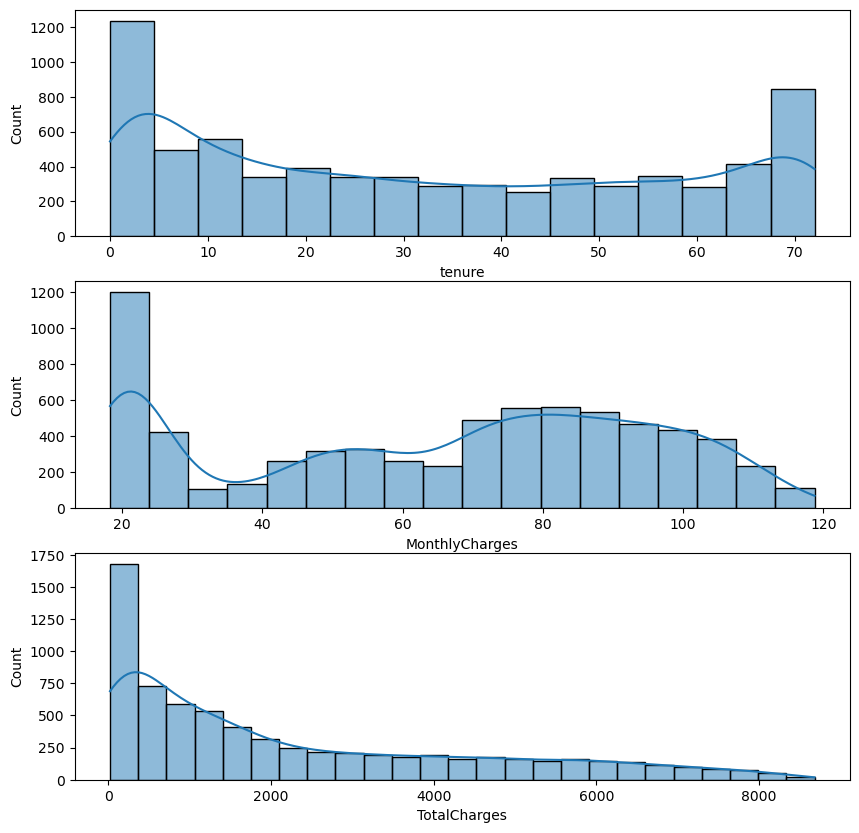

In [35]:
tel['TotalCharges'] = tel['TotalCharges'].replace(['', ' ', 'NA'], np.nan)
tel['TotalCharges']=tel['TotalCharges'].astype(float)
fig,axes=plt.subplots(3,1,figsize=(10,10))
sns.histplot(tel['tenure'],kde=True,ax=axes[0])
sns.histplot(tel['MonthlyCharges'],kde=True,ax=axes[1])
sns.histplot(tel['TotalCharges'],kde=True,ax=axes[2])

<Axes: ylabel='TotalCharges'>

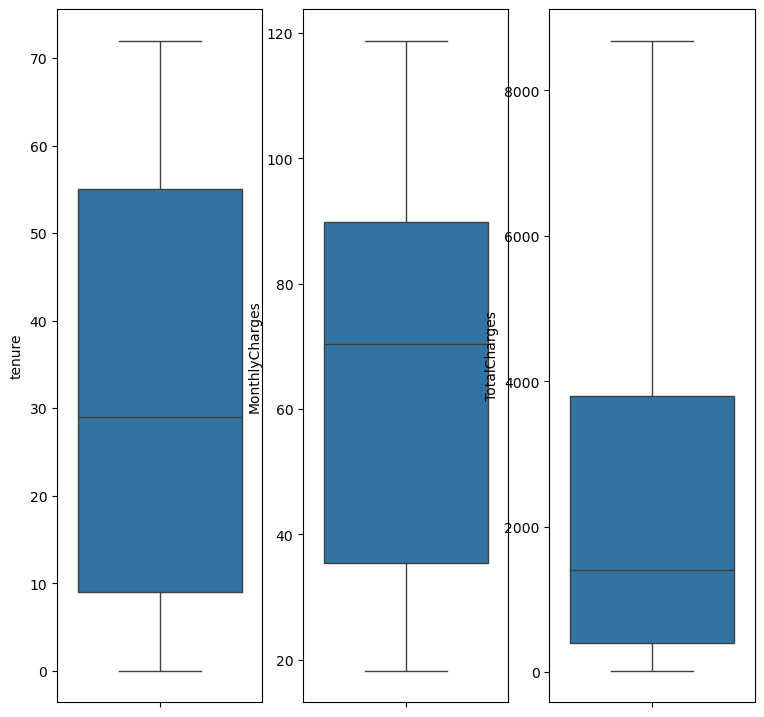

In [37]:
fig,axes=plt.subplots(1,3,figsize=(9,9))
sns.boxplot(tel['tenure'],ax=axes[0])
sns.boxplot(tel['MonthlyCharges'],ax=axes[1])
sns.boxplot(tel['TotalCharges'],ax=axes[2])


In [39]:
tel.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [41]:
# Check distribution
# print(tel['Churn'].value_counts())
print(tel['Churn'].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [43]:
tel.drop(axis=0,columns=['customerID'],inplace=True)

In [45]:
tel.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Easier Way To Encode

In [48]:

# Label encoding:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# df['Gender'] = le.fit_transform(df['Gender'])  # Male->0, Female->1


# # OneHotEncoding
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse=False, drop='first')  # drop='first' avoids multicollinearity
# encoded = ohe.fit_transform(df[['Contract', 'PaymentMethod']])

# # ordinal encoding
# from sklearn.preprocessing import OrdinalEncoder

# # Method 1: Manual mapping
# education_map = {'High School': 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3}
# df['Education'] = df['Education'].map(education_map)

# # Method 2: sklearn
# oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
# df['Satisfaction'] = oe.fit_transform(df[['Satisfaction']])


# D. Target/Mean Encoding (replace with target mean)
# python# For each category, use average of target variable
# target_mean = df.groupby('City')['Churn'].mean()
# df['City_encoded'] = df['City'].map(target_mean)
# When to use:

# High cardinality features (many unique values like City, ZipCode)
# Tree-based models

# Warning: Risk of overfitting! Use with cross-validation

In [50]:
# one-hot_encoding:(get dummies and convert to binary with droping first columns to reduce multicolinarity)
one_h_cols=['Contract','InternetService','PaymentMethod','Churn']
tel=pd.get_dummies(columns=one_h_cols,drop_first=True,data=tel,dtype=int)

# Lable Encoding:(features with 2 to 3 catagory but normally it is organized like high school<bacholer degree<master<phd,Yes,NO and Male,Female)
label_encoding_cols=['gender','Partner','Dependents','PaperlessBilling','PhoneService']
for col in label_encoding_cols:
    if col=='gender':
        tel[col]=tel[col].map({'Male':0,'Female':1})
    else:
        tel[col]=tel[col].map({'Yes':1,'No':0})
# handelilng MultipleLines:
tel['MultipleLines']=tel['MultipleLines'].map({'Yes':1,'No':0,'No phone service':0})

# Handle service columns:
service_cols=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for col in service_cols:
    tel[col]=tel[col].map({'Yes':1,'No':0,'No internet service':0})


In [52]:
tel['TotalCharges']=tel['TotalCharges'].fillna(tel['TotalCharges'].median())

In [54]:
tel.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,1,0,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,1,0,0,0,0,0,1,0
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,0,0,0,0,0,0,1,1
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,1,0,0,0,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,0,0,1,0,0,1,0,1


In [56]:
tel.isnull().sum()

gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
MultipleLines                            0
OnlineSecurity                           0
OnlineBackup                             0
DeviceProtection                         0
TechSupport                              0
StreamingTV                              0
StreamingMovies                          0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Contract_One year                        0
Contract_Two year                        0
InternetService_Fiber optic              0
InternetService_No                       0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
Churn_Yes  

<Axes: >

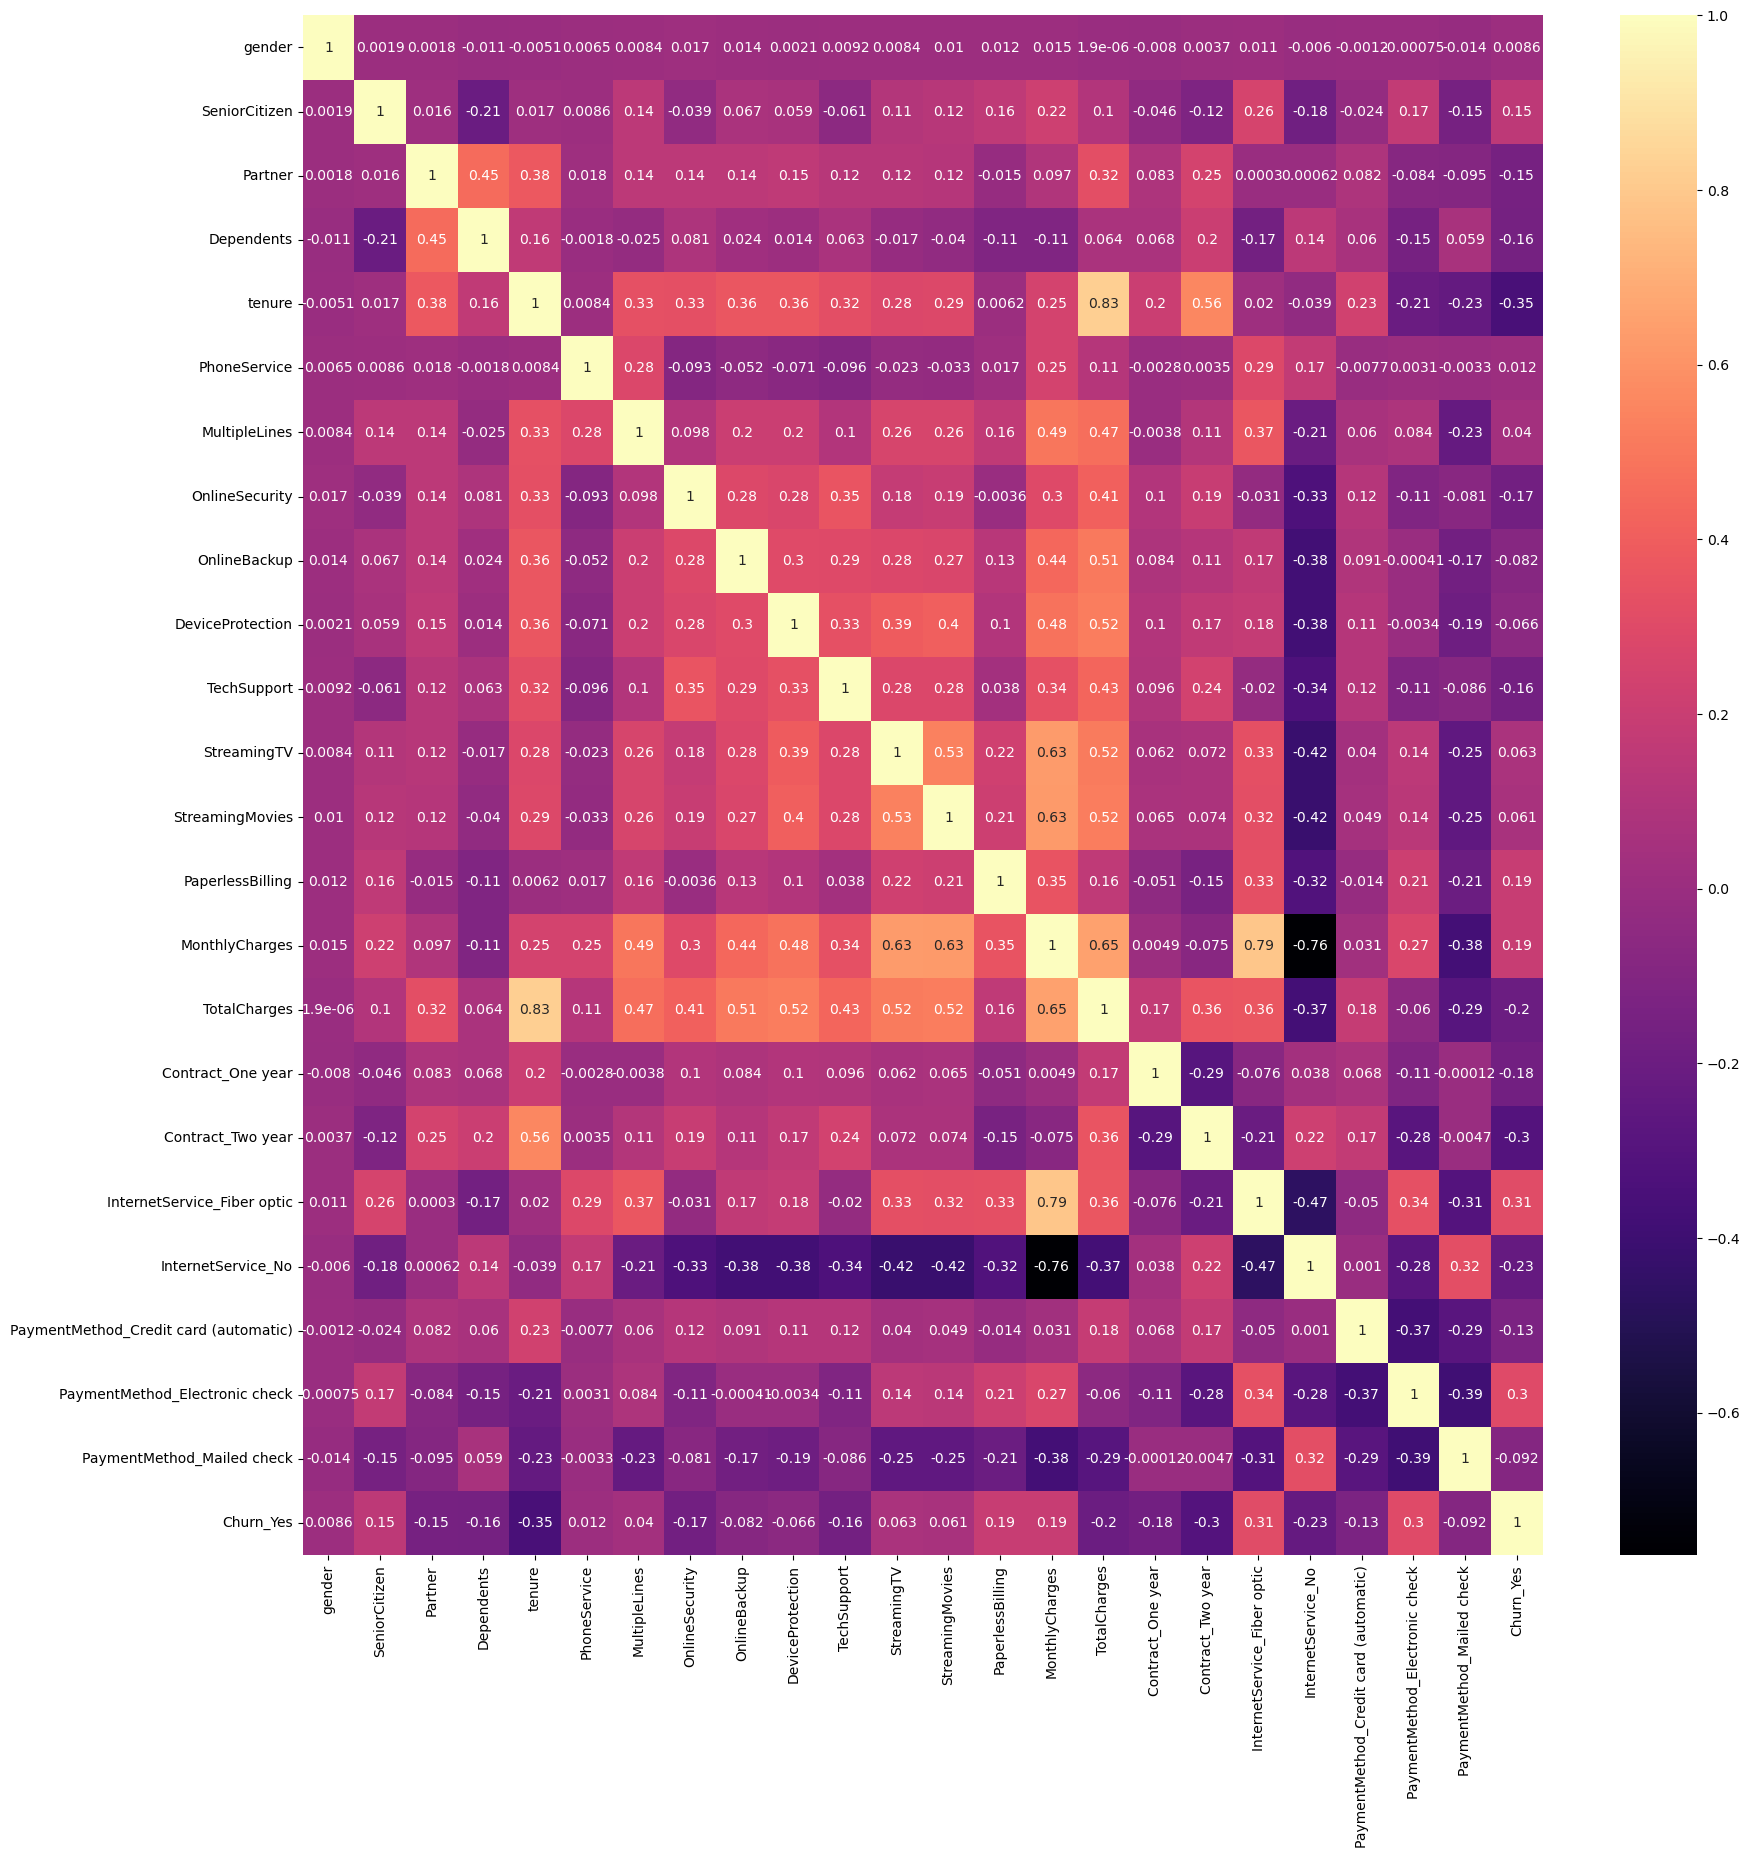

In [58]:
plt.figure(figsize=(20,20))
sns.heatmap(data=tel.corr(),annot=True,cmap='magma')

## Training model

In [61]:
df_train,df_test=train_test_split(tel,test_size=0.2,random_state=42)
# df_test,df_val=train_test_split(df_combine,test_size=0.5,random_state=42)

X_train=df_train
# X_val=df_val
X_test=df_test
y_train=df_train.pop('Churn_Yes')
# y_val=df_val.pop('Churn_Yes')
y_test=df_test.pop('Churn_Yes')

In [108]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
# X_val_scaled=scaler.fit_transform(X_val)
X_test_scaled=scaler.fit_transform(X_test)


## Logistic Regression HyperParameter tunning And Adjusting Class weight bias

- C:regulization Term
- solver/optimizer: decreasing the lost
- n_jobs: the number of cpu that used for this process
- verbose: gives an explenation per fold or it may differ based on the value

### Adjusting the Case of imbalanced Dataset :
- SMOTE
- Random UnderSampling
- Random OverSampling
- Adjusting Weight and bias
- Combinations Approach

In [110]:
print("\n" + "="*60)
print("LOGISTIC REGRESSION - GridSearchCV")
print("="*60)

lm_param_grid={
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
scorer=make_scorer(f1_score)

lr_grid=GridSearchCV(
    LogisticRegression(class_weight='balanced',max_iter=1000,random_state=42),
    param_grid=lm_param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
    
)

lr_grid.fit(X_train_scaled,y_train)


print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best CV f1 score: {lr_grid.best_score_:.4f}")



LOGISTIC REGRESSION - GridSearchCV
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV f1 score: 0.6224


## Testing:

In [112]:
y_test_pred_lr=lr_grid.best_estimator_.predict(X_test_scaled)
y_test_pred_lr_porba=lr_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print("Test evaluation")
print(classification_report(y_test,y_test_pred_lr))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_pred_lr_porba):.4f}")

Test evaluation
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.83      0.63       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

Test ROC-AUC: 0.8619


## Checking overfitting

In [114]:
test_score=f1_score(y_test,lr_grid.best_estimator_.predict(X_test_scaled))
train_score=f1_score(y_train,lr_grid.best_estimator_.predict(X_train_scaled))

print(f"test socre: {test_score}")
print(f"train socre: {train_score}")



test socre: 0.6343975283213182
train socre: 0.6250974279033517


Expected Output:
# Good (not overfitting):
- Training F1: 0.65
- Test F1: 0.63
- Difference: 0.02 ✅

# Overfitting:
- Training F1: 0.80
- Test F1: 0.63
- Difference: 0.17 ❌
- Why F1=0.63 is Low:
- F1 Score Interpretation:
- F1 ScorePerformance0.90-1.00Excellent0.80-0.90Good0.70-0.80Okay0.60-0.70Poor ← Your case< 0.60Very poor

## Random Forest Hyperparameter Tunning:

In [116]:
print("\n" + "="*60)
print("RANDOM FOREST - RandomizedSearchCV")
print("="*60)

rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random=RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced',random_state=42,n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train_scaled,y_train)

print(f"best parameters: {rf_random.best_params_}")
print(f"Best CV f1 score: {rf_random.best_score_:.4f}")

y_test_pred_rnd=rf_random.best_estimator_.predict(X_test_scaled)
y_test_pred_rnd_proba=rf_random.best_estimator_.predict_proba(X_test_scaled)
print("Test based on randomCV")
print(classification_report(y_test,y_test_pred_rnd))
print(f"Test ROC-AUC:{roc_auc_score(y_test,y_test_pred_rnd)}")


RANDOM FOREST - RandomizedSearchCV
Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
Best CV f1 score: 0.6300
Test based on randomCV
              precision    recall  f1-score   support

           0       0.91      0.79      0.84      1036
           1       0.57      0.78      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.79      0.79      1409

Test ROC-AUC:0.7830449656857165


- Accuracy: Used with balanced Dataset only
  
- precision:
    - Meaning: Of all predicted positives, how many were actually positive?
    - Question it answers: "When model says 'churn', how often is it right?"
    - Use when: You want to avoid false alarms (false positives costly)
- Recall:
    - Meaning: Of all actual positives, how many did we catch?
    - Question it answers: "Of all churners, how many did we identify?"
    - Use when: You want to catch all positives (false negatives costly)
- F1 : Used with imbalanced Datasets

- Real-world example:

   - You're looking for defective products (rare - only 5% are defective)
   - High Precision, Low Recall: You only flag items you're SURE are defective, but miss many defects
   - Low Precision, High Recall: You flag everything suspicious, catching all defects but also flagging many good items
   - Good F1: You catch most defects AND don't flag too many good items



### Tring Optuna/Bayesian Optimization :

In [171]:
print("="*60)
print("VERSION 1: USING OPTUNA")
print("="*60)

# Your parameter distributions (keeping your exact values)
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Define objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', rf_param_dist['n_estimators']),
        'max_depth': trial.suggest_categorical('max_depth', rf_param_dist['max_depth']),
        'min_samples_split': trial.suggest_categorical('min_samples_split', rf_param_dist['min_samples_split']),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', rf_param_dist['min_samples_leaf']),
        'max_features': trial.suggest_categorical('max_features', rf_param_dist['max_features']),
        'bootstrap': trial.suggest_categorical('bootstrap', rf_param_dist['bootstrap']),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=scorer, n_jobs=-1).mean()
    return score


VERSION 1: USING OPTUNA


┌─────────────────────────────────────────────────────────┐
│ Optuna starts Trial 1                                   │
├─────────────────────────────────────────────────────────┤
│ 1. Optuna picks: n_estimators=100, max_depth=20        │
│ 2. Create model with these parameters                   │
│ 3. Test with 5-fold cross-validation:                  │
│    Fold 1: 0.86                                         │
│    Fold 2: 0.88                                         │
│    Fold 3: 0.85                                         │
│    Fold 4: 0.87                                         │
│    Fold 5: 0.89                                         │
│ 4. Calculate mean: 0.87                                 │
│ 5. Return 0.87 to Optuna                               │
├─────────────────────────────────────────────────────────┤
│ Optuna records: Trial 1 = 0.87                         │
│ Optuna decides what to try next (using Bayesian magic) │
└─────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────┐
│ Optuna starts Trial 2                                   │
├─────────────────────────────────────────────────────────┤
│ 1. Based on Trial 1, Optuna smartly picks:             │
│    n_estimators=200, max_depth=30                       │
│ 2. Create model... test... calculate mean...           │
│ 3. Return 0.88 to Optuna                               │
├─────────────────────────────────────────────────────────┤
│ Optuna thinks: "0.88 > 0.87, I'm improving!"           │
└─────────────────────────────────────────────────────────┘

... continues for 50 trials ...

┌─────────────────────────────────────────────────────────┐
│ After 50 trials:                                        │
│ Best score found: 0.92                                  │
│ Best parameters: n_estimators=250, max_depth=35, ...   │
└─────────────────────────────────────────────────────────┘

In [166]:
# Create study and optimize
optuna.logging.set_verbosity(optuna.logging.INFO)  # Set to INFO for verbose output
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Create a wrapper class to match BayesSearchCV interface
class OptunaWrapper:
    def __init__(self, study, X_train, y_train):
        self.best_params_ = study.best_params
        self.best_score_ = study.best_value
        self.best_estimator_ = RandomForestClassifier(
            **study.best_params,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        self.best_estimator_.fit(X_train, y_train)

# Create the by_model object (same interface as BayesSearchCV)
by_model = OptunaWrapper(study, X_train_scaled, y_train)

[I 2025-10-12 16:23:06,241] A new study created in memory with name: no-name-cab8235e-11bf-49d7-b67e-9c15efc5559d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-12 16:23:08,089] Trial 0 finished with value: 0.5998089408603141 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.5998089408603141.
[I 2025-10-12 16:23:09,399] Trial 1 finished with value: 0.6057444122061215 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.6057444122061215.
[I 2025-10-12 16:23:09,634] Trial 2 finished with value: 0.607862985826872 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.607862985826872.
[I 2025-10-12 16:23:09,869] Trial 3 finished with value: 0.6036817103955869 and parameters: {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_featu

In [168]:
# Your original code - NOW IT WORKS!
print(f"Best parameters: {by_model.best_params_}")
print(f"F1 Best score: {by_model.best_score_:.4f}")

y_pred_by = by_model.best_estimator_.predict(X_test_scaled)
y_pred_by_prob = by_model.best_estimator_.predict_proba(X_test_scaled)

print("\nTest Set Results:")
print(classification_report(y_test, y_pred_by))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_by_prob[:, 1]):.4f}")

Best parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
F1 Best score: 0.6317

Test Set Results:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1036
           1       0.57      0.76      0.65       373

    accuracy                           0.78      1409
   macro avg       0.73      0.78      0.75      1409
weighted avg       0.81      0.78      0.79      1409

Test ROC-AUC: 0.8552


---

Real-World Decision Guide:
Start with default state If score is good enough → STOP! Don't waste time tuning.then try RandomizeSearchCV if it increase stop and then you can try BayesianSearchCV/optuna
- Use GridSearchCV when:
    - Parameters ≤ 3
    - Values per parameter ≤ 5
    - Total combinations ≤ 50
    - Model trains fast (< 1 second)
    - Example: Logistic Regression with 2-3 params
- Use RandomizedSearchCV when:
    - Parameters: 3-6
    - Total combinations: 100-1000
    - Model trains moderately fast
    - You need results within hours
    - Example: Random Forest, SVM, initial exploration
- Use Bayesian Search (Optuna) when:
    - Parameters > 5
    - Total combinations: 1000+
    - Model is expensive to train (minutes per trial)
    - You need best possible performance
    -  Example: Deep Learning, XGBoost with many params, production models

## Implementing SMOTE:

In [68]:
smote = SMOTE(
    sampling_strategy='auto',  # Balance minority class to match majority
    k_neighbors=5,             # Number of nearest neighbors
    random_state=42
)

# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nBefore SMOTE: {Counter(y_train)}")
print(f"After SMOTE: {Counter(y_train_resampled)}")
print(f"\nSynthetic samples created: {len(y_train_resampled) - len(y_train)}")


Before SMOTE: Counter({0: 4138, 1: 1496})
After SMOTE: Counter({0: 4138, 1: 4138})

Synthetic samples created: 2642


In [82]:
# ============================================================================
# STEP 6: Train Model with Balanced Data
# ============================================================================

print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)
scorer=make_scorer(f1_score)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random=RandomizedSearchCV(
    RandomForestClassifier(random_state=42,n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train a simple model
# model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_random.fit(X_train_scaled, y_train_resampled)

print("Model trained successfully!")


TRAINING MODEL
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Model trained successfully!


In [84]:
# ============================================================================
# STEP 7: Evaluate Model
# ============================================================================

print("\n" + "="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)

# Make predictions
y_test_pred_rnd=rf_random.best_estimator_.predict(X_test_scaled)
y_test_pred_rnd_proba=rf_random.best_estimator_.predict_proba(X_test_scaled)[:, 1]
# y_pred = model.predict(X_test_scaled)
# y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Print metrics
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rnd, target_names=['No Churn', 'Churn']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rnd))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")



MODEL EVALUATION ON TEST SET

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.89      0.81      0.85      1036
       Churn       0.58      0.71      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409


Confusion Matrix:
[[842 194]
 [109 264]]

ROC-AUC Score: 0.8326
